In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
from random import random, randrange, randint, uniform
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
import time

Загрузка набора данных временного ряда

In [2]:
# Загрузка набора данных (ИТС за первые 3 года)
df_ITS_perday = pd.read_excel(r"C:\Users\1\Desktop\Papka\АПР_Прогнозирование ИТС\ITS.xlsx")
df_ITS_perday=df_ITS_perday[['ИТС']]
# df_ITS_perday=df_ITS_perday.set_index('Data')
display(df_ITS_perday)

,ИТС
0,100.0000
1,100.0000
2,100.0000
3,100.0000
4,100.0000
...,...
1090,84.9765
1091,84.9765
1092,84.9765
1093,84.9765


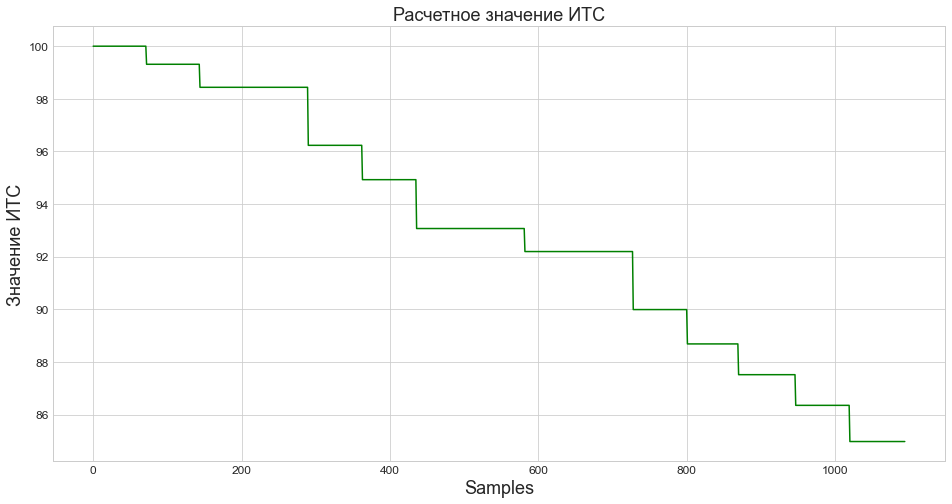

In [3]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16, 8))
plt.plot(df_ITS_perday, 'g')
plt.title('Расчетное значение ИТС', fontsize=18)
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Значение ИТС', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [4]:
def univariate_data(dataset, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(dataset[i+target_size])
    else:
      labels.append(dataset[i:i+target_size])

  return np.array(data), np.array(labels)

In [5]:
def create_time_steps(length):
  return list(range(-length, 0))

In [6]:
def plot_train_history(history, title):
  loss = history.history['loss']
#   val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
#   plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [7]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_ITS_perday)

uni_data = scaler.transform(df_ITS_perday)

print(uni_data)
print(len(uni_data))

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
1095


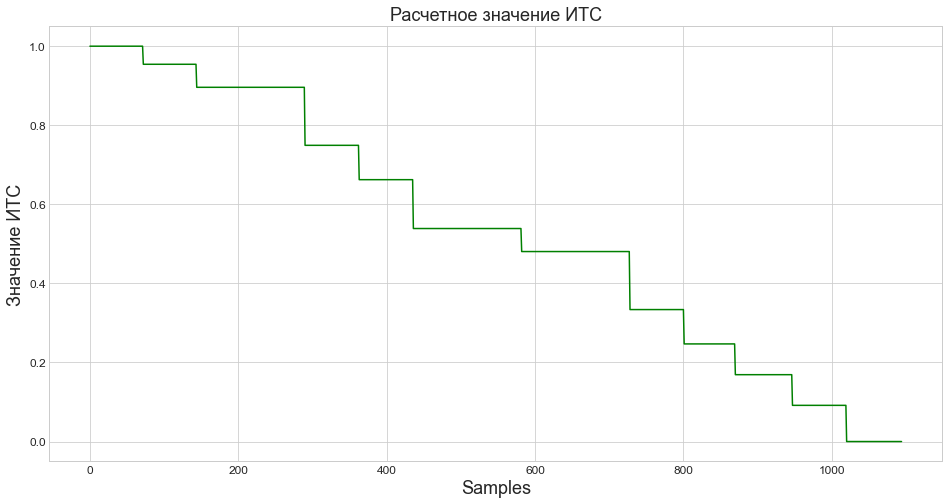

In [9]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16, 8))
plt.plot(uni_data, 'g')
plt.title('Расчетное значение ИТС', fontsize=18)
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Значение ИТС', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [10]:
univariate_past_history = 1094
univariate_future_target = 0
STEP = 1

x_train_uni, y_train_uni = univariate_data(uni_data, 0, len(uni_data),
                                           univariate_past_history,
                                           univariate_future_target, STEP, single_step=True)
# x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
#                                        univariate_past_history,
#                                        univariate_future_target, STEP, single_step=True)

In [11]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target ITS to predict')
print (y_train_uni[0])

Single window of past history
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]

 Target ITS to predict
[0.]


In [12]:
BATCH_SIZE = 128

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().batch(BATCH_SIZE).repeat()

# val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
# val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [13]:
print ('Single window of past history : {}'.format(x_train_uni[0].shape))
print ('Target ITS to predict : {}'.format(y_train_uni[0].shape))
print(x_train_uni.shape[-2])
print(x_train_uni.shape[-1])
print(x_train_uni.shape[0:])
print(x_train_uni.shape[-1:])
print(x_train_uni.shape[-2:])
print(y_train_uni.shape[0:])
print(y_train_uni.shape[-1:])
print(y_train_uni.shape[-2:])

Single window of past history : (1094, 1)
Target ITS to predict : (1,)
1094
1
(1, 1094, 1)
(1,)
(1094, 1)
(1, 1)
(1,)
(1, 1)


In [14]:
model = Sequential()

model.add(LSTM(32, return_sequences = True, input_shape = x_train_uni.shape[-2:]))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1094, 32)          4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='mse', 
              optimizer = 'adam',
              metrics='mae')

In [ ]:
for x, y in train_univariate.take(1):
    print(model.predict(x).shape)

In [16]:
EVALUATION_INTERVAL = 10
EPOCHS = 5

multi_step_history = model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch = EVALUATION_INTERVAL)

Epoch 1/5
10/10 [==============================] - 5s 322ms/step - loss: 1.6062e-06 - mae: 8.3581e-04
Epoch 2/5
10/10 [==============================] - 3s 321ms/step - loss: 1.4128e-07 - mae: 3.0724e-04
Epoch 3/5
10/10 [==============================] - 3s 321ms/step - loss: 2.5817e-08 - mae: 1.4367e-04
Epoch 4/5
10/10 [==============================] - 3s 322ms/step - loss: 1.0994e-08 - mae: 9.8115e-05
Epoch 5/5
10/10 [==============================] - 3s 322ms/step - loss: 3.8476e-09 - mae: 5.0755e-05


1/1 [==============================] - 0s 418ms/step


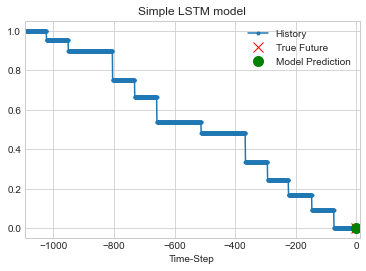

In [17]:
for x, y in train_univariate.take(1):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

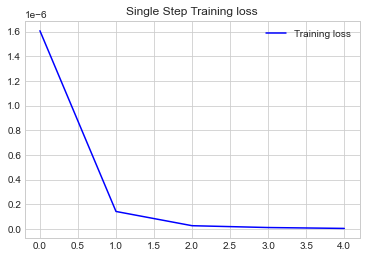

In [18]:
plot_train_history(multi_step_history,
                   'Single Step Training loss')

In [19]:
ITS_predicted = x_train_uni[0].copy()
k=52

for i in range (0, 3650):
    if k==0:
        y_train_uni[0][0] = y_train_uni[0][0] - uniform(0.05,0.15)
        k=randint(70,150)
    k-=1
    
    ITS_predicted = np.vstack((ITS_predicted, model.predict(x_train_uni)))
    x_train_uni[0] = ITS_predicted[i+1:]
    
    train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
    train_univariate = train_univariate.cache().batch(BATCH_SIZE).repeat()
    
    model.fit(train_univariate, epochs=EPOCHS, steps_per_epoch = EVALUATION_INTERVAL)


1/1 [==============================] - 0s 398ms/step
Epoch 1/5
10/10 [==============================] - 3s 326ms/step - loss: 1.4363e-09 - mae: 3.4551e-05
Epoch 2/5
10/10 [==============================] - 3s 322ms/step - loss: 6.5330e-10 - mae: 2.3168e-05
Epoch 3/5
10/10 [==============================] - 3s 322ms/step - loss: 2.3107e-10 - mae: 1.3734e-05
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 8.6775e-11 - mae: 8.1551e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 1.3059e-11 - mae: 3.1741e-06
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 4.6784e-12 - mae: 1.9436e-06
Epoch 3/5
10/10 [==============================] - 3s 327ms/step - loss: 2.1674e-12 - mae: 1.3559e-06
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 7.8998e-13 - mae: 7.7300e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1

10/10 [==============================] - 3s 332ms/step - loss: 1.4530e-13 - mae: 3.2657e-07
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 8.8859e-14 - mae: 2.9081e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 2.4572e-11 - mae: 4.3122e-06
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 9.8078e-10 - mae: 2.7310e-05
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 1.0168e-07 - mae: 2.6915e-04
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 2.2609e-07 - mae: 4.3021e-04
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 1.4888e-08 - mae: 1.0647e-04
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 6.0441e-09 - mae: 6.9669e-05
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 1.0654e-12 - mae: 9.1582e-07
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 3.3412e-13 - mae: 5.0762e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 1.5777e-13 - mae: 3.3979e-07
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 5.9034e-14 - mae: 2.2450e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 3.0448e-14 - mae: 1.5739e-07
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 1.2318e-14 - mae: 1.0082e-07
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 1.8619e-15 - mae: 3.7020e-08
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 1.0658e-15 - mae: 2.8778e-08
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 328ms/step - loss: 1.0474e-15 - mae: 2.9011e-08
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 3.9699e-16 - mae: 1.7323e-08
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 1.2332e-13 - mae: 3.0841e-07
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 5.5030e-14 - mae: 2.0945e-07
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 2.8869e-14 - mae: 1.6177e-07
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 7.6919e-15 - mae: 8.0606e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 2.0021e-12 - mae: 1.3058e-06
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 5.4176e-12 - mae: 2.3149e-06
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 333ms/step - loss: 1.8620e-08 - mae: 1.2055e-04
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 6.3851e-09 - mae: 6.9354e-05
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 2.1991e-09 - mae: 4.0970e-05
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 7.5742e-10 - mae: 2.4661e-05
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 8.9677e-09 - mae: 8.5001e-05
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 2.8401e-09 - mae: 4.8175e-05
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 9.3074e-10 - mae: 2.7670e-05
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 3.3532e-10 - mae: 1.5853e-05
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - los

10/10 [==============================] - 3s 330ms/step - loss: 1.7685e-12 - mae: 1.1861e-06
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 3.9142e-11 - mae: 5.6162e-06
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 1.3591e-11 - mae: 3.3058e-06
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 4.7097e-12 - mae: 1.9245e-06
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 1.6299e-12 - mae: 1.1392e-06
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 3.6934e-11 - mae: 5.4955e-06
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 1.2577e-11 - mae: 3.1456e-06
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 4.2879e-12 - mae: 1.8403e-06
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - los

10/10 [==============================] - 3s 330ms/step - loss: 1.1078e-12 - mae: 9.1493e-07
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 4.0279e-13 - mae: 5.5730e-07
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 1.2543e-13 - mae: 3.1739e-07
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 5.2908e-14 - mae: 2.1383e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 7.6647e-13 - mae: 7.6815e-07
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 2.8539e-13 - mae: 4.7609e-07
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 8.4743e-14 - mae: 2.5630e-07
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 3.6326e-14 - mae: 1.6987e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 330ms/step - loss: 1.1657e-16 - mae: 9.6858e-09
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 1.1102e-17 - mae: 1.4901e-09
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 1.7208e-16 - mae: 1.1176e-08
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 1.8319e-16 - mae: 1.2666e-08
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 1.6653e-16 - mae: 1.1921e-08
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - los

10/10 [==============================] - 3s 330ms/step - loss: 1.4932e-15 - mae: 3.3528e-08
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 2.9976e-16 - mae: 1.6391e-08
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 2.7756e-17 - mae: 3.7253e-09
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 3.8858e-17 - mae: 5.2154e-09
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 7.4940e-16 - mae: 2.3097e-08
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 3.4417e-16 - mae: 1.3411e-08
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 1.0547e-16 - mae: 8.1956e-09
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 2.2204e-17 - mae: 2.9802e-09
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 330ms/step - loss: 5.0515e-16 - mae: 2.0117e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 2.2204e-16 - mae: 1.3411e-08
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 2.7756e-17 - mae: 3.7253e-09
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 2.7756e-16 - mae: 1.4901e-08
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 6.1062e-16 - mae: 2.2352e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 1.4211e-15 - mae: 3.2783e-08
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 5.1070e-16 - mae: 2.0862e-08
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 4.7740e-16 - mae: 1.7881e-08
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 331ms/step - loss: 3.0531e-15 - mae: 4.6194e-08
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 8.0103e-15 - mae: 8.1211e-08
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 3.8192e-15 - mae: 5.5134e-08
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 1.0547e-15 - mae: 2.9802e-08
Epoch 5/5
1/1 [==============================] - 0s 70ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 1.8818e-15 - mae: 3.7998e-08
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 1.5099e-15 - mae: 3.4273e-08
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 9.2149e-16 - mae: 2.8312e-08
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 4.8572e-15 - mae: 6.0350e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - los

10/10 [==============================] - 3s 330ms/step - loss: 2.8967e-10 - mae: 1.5241e-05
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 3.9338e-09 - mae: 5.5709e-05
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 1.3310e-09 - mae: 3.2900e-05
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 4.4113e-10 - mae: 1.9027e-05
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 1.5583e-10 - mae: 1.1445e-05
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 2.3026e-11 - mae: 4.0628e-06
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 1.5098e-11 - mae: 3.5703e-06
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 4.3344e-12 - mae: 1.8649e-06
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - los

10/10 [==============================] - 3s 331ms/step - loss: 3.9750e-12 - mae: 1.8112e-06
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 1.0842e-12 - mae: 8.9556e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 1.6472e-12 - mae: 1.2763e-06
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 2.0609e-13 - mae: 3.5167e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 4.0058e-11 - mae: 5.5701e-06
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 1.4202e-09 - mae: 3.3429e-05
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 7.7865e-08 - mae: 2.4474e-04
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 1.9328e-07 - mae: 3.9486e-04
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - los

10/10 [==============================] - 3s 330ms/step - loss: 1.0478e-11 - mae: 3.0041e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0045 - mae: 0.0552
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 3.6241e-04 - mae: 0.0171
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 1.1920e-04 - mae: 0.0097
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 3.5341e-05 - mae: 0.0053
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 2.8567e-06 - mae: 0.0014
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 1.4797e-06 - mae: 0.0011
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 4.9933e-07 - mae: 6.4433e-04
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 1.2179e-07 - mae: 2.9913e

10/10 [==============================] - 3s 332ms/step - loss: 6.7660e-10 - mae: 2.2791e-05
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 2.3549e-10 - mae: 1.4123e-05
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 7.3257e-11 - mae: 7.7039e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 1.0518e-09 - mae: 2.8451e-05
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 4.0537e-10 - mae: 1.7649e-05
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 1.4367e-10 - mae: 1.0653e-05
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 4.6811e-11 - mae: 6.2823e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 6.1256e-10 - mae: 2.1823e-05
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - los

1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 7.0502e-12 - mae: 2.3842e-06
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 2.0695e-12 - mae: 1.3053e-06
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 7.5409e-13 - mae: 7.5549e-07
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 3.3014e-13 - mae: 5.2154e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 5.5228e-12 - mae: 2.1085e-06
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 1.5997e-12 - mae: 1.1370e-06
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 5.8471e-13 - mae: 6.6906e-07
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 2.4927e-13 - mae: 4.4405e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 331ms/step - loss: 7.7494e-15 - mae: 8.1956e-08
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 3.5305e-15 - mae: 4.9174e-08
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 1.6209e-15 - mae: 3.7253e-08
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 1.0170e-14 - mae: 8.6427e-08
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 3.7526e-15 - mae: 5.5134e-08
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 3.5527e-16 - mae: 1.4901e-08
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 1.9984e-16 - mae: 1.0431e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 4.3965e-15 - mae: 5.6624e-08
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 1.1102e-16 - mae: 7.4506e-09
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 2.4425e-16 - mae: 1.0431e-08
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 4.8850e-16 - mae: 1.7881e-08
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 1.3323e-16 - mae: 5.9605e-09
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 3.2438e-08 - mae: 1.5981e-04
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 1.0089e-08 - mae: 8.9356e-05
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 3.5137e-09 - mae: 5.1475e-05
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 1.4037e-09 - mae: 3.4595e-05
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 2.6006e-08 - mae: 1.4099e-04
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 8.6608e-09 - mae: 8.4466e-05
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 2.6220e-09 - mae: 4.4569e-05
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 1.2320e-09 - mae: 3.2327e-05
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 331ms/step - loss: 3.5669e-12 - mae: 1.6391e-06
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 1.2911e-12 - mae: 1.0014e-06
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 4.6674e-13 - mae: 6.2883e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 3.2047e-12 - mae: 1.5795e-06
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 1.2087e-12 - mae: 9.4473e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 4.3352e-13 - mae: 5.8115e-07
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 1.4273e-13 - mae: 3.3081e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 7.0273e-13 - mae: 7.3910e-07
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 3.4728e-14 - mae: 1.6987e-07
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 9.5035e-15 - mae: 8.6427e-08
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 2.5757e-15 - mae: 4.4703e-08
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 4.4409e-16 - mae: 8.9407e-09
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 2.4070e-14 - mae: 1.4007e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 8.9706e-15 - mae: 8.0466e-08
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 5.1514e-15 - mae: 6.5565e-08
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 2.8422e-15 - mae: 4.7684e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 346ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/

10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 3.3162e-08 - mae: 1.5665e-04
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 1.2701e-08 - mae: 1.0375e-04
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 3.1435e-09 - mae: 4.9964e-05
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 1.6215e-09 - mae: 3.6424e-05
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 2.0057e-08 - mae: 1.2332e-04
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 8.0822e-09 - mae: 8.2844e-05
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 1.9593e-09 - mae: 3.8162e-05
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 9.2721e-10 - mae: 2.6295e-05
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 333ms/step - loss: 2.1591e-12 - mae: 1.2964e-06
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 7.8630e-13 - mae: 7.6592e-07
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 2.9532e-13 - mae: 4.7386e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 2.7354e-12 - mae: 1.4722e-06
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 9.6581e-13 - mae: 8.8215e-07
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 3.5030e-13 - mae: 5.2452e-07
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 1.3722e-13 - mae: 3.3081e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 1.2027e-12 - mae: 9.6858e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 1.7764e-16 - mae: 5.9605e-09
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 8.8818e-17 - mae: 2.9802e-09
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 5.3291e-16 - mae: 1.7881e-08
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 4.4409e-16 - mae: 1.4901e-08
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 1.7764e-16 - mae: 5.9605e-09
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/

10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 332ms/step - loss: 1.2866e-08 - mae: 1.0235e-04
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 5.3655e-09 - mae: 6.6373e-05
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 6.8066e-08 - mae: 2.3856e-04
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 1.6457e-08 - mae: 1.0948e-04
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 8.1449e-09 - mae: 8.1539e-05
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 3.0769e-09 - mae: 5.0402e-05
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 3.9901e-08 - mae: 1.8252e-04
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 9.6270e-09 - mae: 8.4257e-05
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - los

1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 3.4715e-11 - mae: 5.1111e-06
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 1.2002e-11 - mae: 3.1739e-06
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 3.4727e-12 - mae: 1.6004e-06
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 1.7866e-12 - mae: 1.2368e-06
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 1.9070e-11 - mae: 3.7730e-06
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 7.0683e-12 - mae: 2.4557e-06
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 1.7492e-12 - mae: 1.1683e-06
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 8.9004e-13 - mae: 8.4937e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 8.8818e-17 - mae: 2.9802e-09
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 2.8422e-15 - mae: 4.7684e-08
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 1.9540e-15 - mae: 3.5763e-08
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 4.4409e-16 - mae: 8.9407e-09
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 8.8818e-17 - mae: 2.9802e-09
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 1.1546e-15 - mae: 2.6822e-08
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - los

10/10 [==============================] - 3s 333ms/step - loss: 1.0844e-06 - mae: 9.3523e-04
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 3.1826e-07 - mae: 5.1582e-04
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 9.3711e-08 - mae: 2.7898e-04
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 3.4465e-08 - mae: 1.5752e-04
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 8.5873e-07 - mae: 8.3199e-04
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 2.4540e-07 - mae: 4.5714e-04
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 7.2846e-08 - mae: 2.3807e-04
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 2.8785e-08 - mae: 1.4686e-04
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - los

10/10 [==============================] - 3s 331ms/step - loss: 2.2890e-11 - mae: 4.1962e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 4.0216e-10 - mae: 1.8239e-05
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 9.9988e-11 - mae: 8.7142e-06
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 5.4287e-11 - mae: 6.7413e-06
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 1.1566e-11 - mae: 2.9683e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 2.2056e-10 - mae: 1.3494e-05
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 5.5804e-11 - mae: 6.4611e-06
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 2.9920e-11 - mae: 4.9472e-06
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - los

10/10 [==============================] - 3s 334ms/step - loss: 2.7711e-14 - mae: 1.4305e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 3.1974e-15 - mae: 5.3644e-08
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 2.8422e-15 - mae: 4.7684e-08
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 1.4211e-15 - mae: 2.3842e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 1.8474e-14 - mae: 1.0729e-07
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 4.9738e-15 - mae: 5.9605e-08
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 2.4869e-15 - mae: 4.1723e-08
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 2.1316e-15 - mae: 3.5763e-08
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - los

10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - los

10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - los

10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - los

10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 321ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - los

10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 319ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 327ms/step - loss: 4.3381e-10 - mae: 1.8257e-05
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 8.6292e-09 - mae: 8.4001e-05
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 2.3326e-09 - mae: 4.1562e-05
Epoch 3/5
10/10 [==============================] - 3s 325ms/step - loss: 1.0798e-09 - mae: 2.9862e-05
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 2.7798e-10 - mae: 1.4430e-05
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 5.1353e-09 - mae: 6.4540e-05
Epoch 2/5
10/10 [==============================] - 3s 326ms/step - loss: 1.4481e-09 - mae: 3.3337e-05
Epoch 3/5
10/10 [==============================] - 3s 327ms/step - loss: 6.1639e-10 - mae: 2.2137e-05
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - los

10/10 [==============================] - 3s 327ms/step - loss: 1.1813e-12 - mae: 9.4771e-07
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 4.6150e-13 - mae: 6.0201e-07
Epoch 3/5
10/10 [==============================] - 3s 327ms/step - loss: 1.4460e-13 - mae: 3.5167e-07
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 2.8066e-14 - mae: 1.4901e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 7.2795e-13 - mae: 7.4506e-07
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 2.8102e-13 - mae: 4.7088e-07
Epoch 3/5
10/10 [==============================] - 3s 327ms/step - loss: 1.0445e-13 - mae: 2.9802e-07
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 3.0909e-14 - mae: 1.4901e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - los

10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 326ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - los

10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - los

10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 326ms/step - los

10/10 [==============================] - 3s 329ms/step - loss: 1.2962e-09 - mae: 3.1531e-05
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 2.2807e-08 - mae: 1.3558e-04
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 6.6051e-09 - mae: 7.1776e-05
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 2.6403e-09 - mae: 4.5192e-05
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 8.6634e-10 - mae: 2.6274e-05
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 1.3574e-08 - mae: 1.0380e-04
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 4.1416e-09 - mae: 5.7232e-05
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 1.4856e-09 - mae: 3.3641e-05
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - los

10/10 [==============================] - 3s 331ms/step - loss: 3.2703e-12 - mae: 1.5914e-06
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 1.1994e-12 - mae: 9.5367e-07
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 4.0536e-13 - mae: 5.9009e-07
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 1.0445e-13 - mae: 2.8610e-07
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 1.9735e-12 - mae: 1.2338e-06
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 8.0362e-13 - mae: 7.7486e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 3.3538e-13 - mae: 5.2452e-07
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 1.0232e-13 - mae: 2.8610e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - los

10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 1.7764e-15 - mae: 2.9802e-08
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 3.1974e-15 - mae: 5.3644e-08
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 3.1974e-15 - mae: 5.3644e-08
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 2.4869e-15 - mae: 4.1723e-08
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - los

10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - los

10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - los

10/10 [==============================] - 3s 329ms/step - loss: 0.0053 - mae: 0.0631
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0017 - mae: 0.0377
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 3.4630e-04 - mae: 0.0160
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 1.7820e-04 - mae: 0.0122
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 1.5195e-05 - mae: 0.0033
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 7.9753e-06 - mae: 0.0026
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 2.3347e-06 - mae: 0.0014
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 6.7868e-07 - mae: 7.0397e-04
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 3.1068e-07 - mae: 5.0773e-04
Epoc

10/10 [==============================] - 3s 330ms/step - loss: 3.3255e-10 - mae: 1.6445e-05
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 3.7710e-09 - mae: 5.3060e-05
Epoch 2/5
10/10 [==============================] - 3s 327ms/step - loss: 1.4708e-09 - mae: 3.5167e-05
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 3.5866e-10 - mae: 1.6761e-05
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 1.8079e-10 - mae: 1.2058e-05
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 2.0640e-09 - mae: 3.9649e-05
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 8.4130e-10 - mae: 2.6822e-05
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 2.0607e-10 - mae: 1.2523e-05
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 330ms/step - loss: 6.2030e-13 - mae: 6.9141e-07
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 2.5544e-13 - mae: 4.3511e-07
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 1.1333e-13 - mae: 2.8014e-07
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 4.6185e-14 - mae: 2.0266e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 3.4461e-13 - mae: 5.0068e-07
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 7.7449e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 3.4106e-14 - mae: 1.6689e-07
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 1.2434e-14 - mae: 8.9407e-08
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - los

10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 3.5527e-15 - mae: 5.9605e-08
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 9.9476e-15 - mae: 9.5367e-08
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 5.6843e-15 - mae: 7.1526e-08
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 2.8422e-15 - mae: 4.7684e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 2.1316e-15 - mae: 3.5763e-08
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 1.0658e-15 - mae: 1.7881e-08
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 1.7764e-15 - mae: 2.9802e-08
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - los

10/10 [==============================] - 3s 331ms/step - loss: 4.9738e-15 - mae: 4.7684e-08
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 2.4869e-15 - mae: 4.1723e-08
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 3.5527e-16 - mae: 5.9605e-09
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - los

10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - los

10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - los

10/10 [==============================] - 3s 328ms/step - loss: 0.0014 - mae: 0.0324
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 3.9220e-04 - mae: 0.0178
Epoch 3/5
10/10 [==============================] - 3s 327ms/step - loss: 1.4152e-04 - mae: 0.0105
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 4.9005e-05 - mae: 0.0062
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 6.6513e-06 - mae: 0.0023
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 2.3189e-06 - mae: 0.0014
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 8.0806e-07 - mae: 8.0273e-04
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 2.8154e-07 - mae: 4.7392e-04
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 2.4798e-07 - mae: 4.4353e

10/10 [==============================] - 3s 328ms/step - loss: 5.0701e-11 - mae: 6.3896e-06
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 7.7068e-10 - mae: 2.4688e-05
Epoch 2/5
10/10 [==============================] - 3s 327ms/step - loss: 2.1592e-10 - mae: 1.3041e-05
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 1.0277e-10 - mae: 9.0003e-06
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 3.0960e-11 - mae: 5.0306e-06
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 325ms/step - loss: 4.6677e-10 - mae: 1.9491e-05
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 1.3473e-10 - mae: 9.8586e-06
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 6.1077e-11 - mae: 7.1645e-06
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - los

10/10 [==============================] - 3s 329ms/step - loss: 3.3964e-13 - mae: 5.1260e-07
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 1.5916e-13 - mae: 3.5763e-07
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 6.5370e-14 - mae: 2.1458e-07
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 1.1369e-14 - mae: 7.1526e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 1.6200e-13 - mae: 3.3379e-07
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 3.8369e-14 - mae: 1.5497e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 3.1264e-14 - mae: 1.4305e-07
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 2.7001e-14 - mae: 1.3113e-07
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - los

10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - los

10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0014 - mae: 0.0331
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 4.0904e-04 - mae: 0.0180
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 1.4772e-04 - mae: 0.0109
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 5.1323e-05 - 

10/10 [==============================] - 3s 338ms/step - loss: 4.4588e-10 - mae: 1.8609e-05
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 1.8008e-10 - mae: 1.1933e-05
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 7.2168e-11 - mae: 7.7009e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 1.0101e-09 - mae: 2.8396e-05
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 2.7567e-10 - mae: 1.4567e-05
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 1.1700e-10 - mae: 9.8467e-06
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 4.2746e-11 - mae: 5.8174e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 6.5124e-10 - mae: 2.2721e-05
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 4.2917e-13 - mae: 5.7220e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 2.0464e-13 - mae: 3.8147e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 4.5475e-14 - mae: 1.9073e-07
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 1.2790e-14 - mae: 1.0729e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 1.7053e-13 - mae: 3.3379e-07
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 7.8160e-14 - mae: 2.5034e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 2.7001e-14 - mae: 1.3113e-07
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 1.9895e-14 - mae: 1.1921e-07
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/

10/10 [==============================] - 3s 340ms/step - loss: 1.4211e-15 - mae: 1.1921e-08
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 5.6843e-15 - mae: 4.7684e-08
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 2.8422e-15 - mae: 2.3842e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - los

1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 341ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 344ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 341ms/step - los

1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 343ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 342ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 351ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - los

1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 1.7374e-08 - mae: 1.1545e-04
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 6.7175e-09 - mae: 7.1871e-05
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 2.3786e-09 - mae: 4.3857e-05
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 7.6602e-10 - mae: 2.5165e-05
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 1.1420e-08 - mae: 9.4056e-05
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 4.3386e-09 - mae: 5.7459e-05
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 1.5523e-09 - mae: 3.4773e-05
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 5.1995e-10 - mae: 2.1052e-05
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 336ms/step - loss: 3.7630e-12 - mae: 1.7643e-06
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 1.4154e-12 - mae: 1.0014e-06
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 6.5654e-13 - mae: 7.1526e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 7.2291e-12 - mae: 2.4199e-06
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 2.0279e-12 - mae: 1.2755e-06
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 6.4091e-13 - mae: 7.0333e-07
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 2.6006e-13 - mae: 4.6492e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 4.2178e-12 - mae: 1.8358e-06
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 339ms/step - loss: 2.5580e-14 - mae: 1.4305e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 1.2790e-14 - mae: 1.0729e-07
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 7.1054e-15 - mae: 5.9605e-08
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 1.2790e-14 - mae: 1.0729e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 5.6843e-15 - mae: 4.7684e-08
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 8.5265e-15 - mae: 7.1526e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 334ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - los

1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 337ms/step - loss: 7.1054e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 7.1054e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 7.1054e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 7.1054e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 7.1054e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 7.1054e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 7.1054e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 7.5318e-14 - mae: 2.5034e-07
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 4.8076e-08 - mae: 1.9221e-04
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 2.0538e-08 - mae: 1.3102e-04
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 5.7054e-09 - mae: 6.5863e-05
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 1.8135e-09 - mae: 3.7956e-05
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 2.9590e-08 - mae: 1.5030e-04
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 1.2572e-08 - mae: 1.0058e-04
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 3.7195e-09 - mae: 5.5075e-05
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 1.0909e-09 - mae: 2.9206e-05
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 334ms/step - loss: 2.1464e-11 - mae: 4.1485e-06
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 7.6270e-12 - mae: 2.5392e-06
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 2.4144e-12 - mae: 1.3947e-06
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 3.4585e-11 - mae: 5.2094e-06
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 1.1761e-11 - mae: 3.1233e-06
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 4.3300e-12 - mae: 1.8477e-06
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 1.4282e-12 - mae: 1.1086e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 1.9622e-11 - mae: 3.9577e-06
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - los

1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 4.1211e-14 - mae: 1.7881e-07
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 3.4106e-14 - mae: 1.4305e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 5.4001e-14 - mae: 1.9073e-07
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 3.8369e-14 - mae: 1.7881e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 1.8474e-14 - mae: 1.0729e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 1.4211e-15 - mae: 1.1921e-08
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 338ms/step - loss: 5.4990e-09 - mae: 6.7365e-05
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 1.5165e-09 - mae: 3.4523e-05
Epoch 5/5
1/1 [==============================] - 0s 71ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 3.8761e-08 - mae: 1.7589e-04
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 1.0780e-08 - mae: 9.1648e-05
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 4.8149e-09 - mae: 6.2430e-05
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 1.6021e-09 - mae: 3.6263e-05
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 3.0142e-08 - mae: 1.5424e-04
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 8.3651e-09 - mae: 8.1027e-05
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 339ms/step - loss: 9.3902e-11 - mae: 8.5831e-06
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 3.6394e-11 - mae: 5.2214e-06
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 1.3283e-11 - mae: 3.3736e-06
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 4.8786e-12 - mae: 1.9908e-06
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 5.8735e-11 - mae: 6.8069e-06
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 2.1826e-11 - mae: 4.1366e-06
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 7.5545e-12 - mae: 2.4080e-06
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 2.5636e-12 - mae: 1.4305e-06
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/

10/10 [==============================] - 3s 336ms/step - loss: 7.1054e-15 - mae: 5.9605e-08
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 2.4158e-14 - mae: 1.3113e-07
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 3.9790e-14 - mae: 1.9073e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 2.5580e-14 - mae: 1.4305e-07
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 5.6843e-15 - mae: 4.7684e-08
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 2.2737e-14 - mae: 9.5367e-08
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 2.8422e-15 - mae: 2.3842e-08
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - los

1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 1.7053e-14 - mae: 9.5367e-08
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 1.7053e-14 - mae: 9.5367e-08
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 1.7053e-14 - mae: 9.5367e-08
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 2.7001e-14 - mae: 1.5497e-07
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 3.1264e-14 - mae: 1.6689e-07
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 3.1264e-14 - mae: 1.6689e-07
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 4.8317e-14 - mae: 2.1458e-07
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 337ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 70ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 339ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 339ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - los

Epoch 1/5
10/10 [==============================] - 3s 339ms/step - loss: 4.0401e-12 - mae: 1.7524e-06
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 9.1518e-13 - mae: 8.3447e-07
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 1.9611e-13 - mae: 4.0531e-07
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 4.7606e-13 - mae: 6.3181e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 339ms/step - loss: 2.9019e-12 - mae: 1.5259e-06
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 1.4296e-12 - mae: 1.0729e-06
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 2.1458e-13 - mae: 3.9339e-07
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 3.1122e-13 - mae: 4.6492e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/

10/10 [==============================] - 3s 340ms/step - loss: 2.0037e-13 - mae: 3.6955e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 8.3844e-14 - mae: 2.5034e-07
Epoch 2/5
10/10 [==============================] - 3s 339ms/step - loss: 2.9132e-13 - mae: 4.6492e-07
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 7.5886e-13 - mae: 7.8678e-07
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 2.3306e-13 - mae: 4.2915e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 6.7359e-13 - mae: 7.3910e-07
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 1.5518e-12 - mae: 1.1206e-06
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 7.1907e-13 - mae: 7.1526e-07
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - los

10/10 [==============================] - 3s 335ms/step - loss: 3.9373e-09 - mae: 5.6243e-05
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 1.4652e-09 - mae: 3.3545e-05
Epoch 4/5
10/10 [==============================] - 3s 343ms/step - loss: 6.1609e-10 - mae: 2.2161e-05
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 9.7250e-09 - mae: 8.8286e-05
Epoch 2/5
10/10 [==============================] - 3s 339ms/step - loss: 2.7232e-09 - mae: 4.5967e-05
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 1.0874e-09 - mae: 2.9278e-05
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 4.3164e-10 - mae: 1.8871e-05
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 6.8359e-09 - mae: 7.3898e-05
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - los

1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 1.1894e-11 - mae: 3.0279e-06
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 4.4281e-12 - mae: 1.8835e-06
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 1.5433e-12 - mae: 1.1206e-06
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 5.5280e-13 - mae: 6.7949e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 7.8714e-12 - mae: 2.4438e-06
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 2.8280e-12 - mae: 1.5259e-06
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 9.2371e-13 - mae: 8.8215e-07
Epoch 4/5
10/10 [==============================] - 3s 339ms/step - loss: 3.0838e-13 - mae: 4.8876e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 335ms/step - loss: 1.1369e-14 - mae: 4.7684e-08
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 1.7053e-14 - mae: 7.1526e-08
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 1.1369e-14 - mae: 4.7684e-08
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 2.2737e-14 - mae: 9.5367e-08
Epoch 2/5
10/10 [==============================] - 4s 353ms/step - loss: 4.5475e-14 - mae: 1.9073e-07
Epoch 3/5
10/10 [==============================] - 4s 366ms/step - loss: 4.6896e-14 - mae: 1.7881e-07
Epoch 4/5
10/10 [==============================] - 4s 360ms/step - loss: 4.4054e-14 - mae: 2.0266e-07
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 341ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0062 - mae: 0.0697
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0015 - mae: 0.0336
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 6.7555e-04 - mae: 0.0234
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 1.8677e-04 - mae: 0.0120
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [===============

10/10 [==============================] - 3s 337ms/step - loss: 1.7674e-10 - mae: 1.1647e-05
Epoch 4/5
10/10 [==============================] - 3s 339ms/step - loss: 6.2185e-11 - mae: 7.1883e-06
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 342ms/step - loss: 8.5271e-10 - mae: 2.5868e-05
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 3.1546e-10 - mae: 1.5283e-05
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 1.1464e-10 - mae: 9.4771e-06
Epoch 4/5
10/10 [==============================] - 3s 340ms/step - loss: 4.0706e-11 - mae: 5.6028e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 5.6377e-10 - mae: 2.1100e-05
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 2.0424e-10 - mae: 1.2422e-05
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 6.7786e-13 - mae: 7.2718e-07
Epoch 2/5
10/10 [==============================] - 3s 340ms/step - loss: 1.8758e-13 - mae: 3.8147e-07
Epoch 3/5
10/10 [==============================] - 3s 340ms/step - loss: 5.2580e-14 - mae: 2.0266e-07
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 7.1054e-15 - mae: 5.9605e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 5.6417e-13 - mae: 6.7949e-07
Epoch 2/5
10/10 [==============================] - 3s 340ms/step - loss: 1.7479e-13 - mae: 3.4571e-07
Epoch 3/5
10/10 [==============================] - 3s 341ms/step - loss: 1.7906e-13 - mae: 4.0531e-07
Epoch 4/5
10/10 [==============================] - 3s 342ms/step - loss: 5.6843e-14 - mae: 1.9073e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 341ms/step - loss: 2.9843e-14 - mae: 1.5497e-07
Epoch 4/5
10/10 [==============================] - 3s 339ms/step - loss: 4.1211e-14 - mae: 1.7881e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 3.1264e-14 - mae: 1.4305e-07
Epoch 2/5
10/10 [==============================] - 3s 341ms/step - loss: 9.9476e-15 - mae: 8.3447e-08
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 1.1369e-14 - mae: 9.5367e-08
Epoch 4/5
10/10 [==============================] - 3s 340ms/step - loss: 2.8422e-15 - mae: 2.3842e-08
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 9.9476e-15 - mae: 8.3447e-08
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 8.5265e-15 - mae: 7.1526e-08
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - los

1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 341ms/step - loss: 1.2790e-14 - mae: 1.0729e-07
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 5.2580e-14 - mae: 2.0266e-07
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 1.4211e-14 - mae: 9.5367e-08
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 5.6843e-15 - mae: 4.7684e-08
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 7.1054e-15 - mae: 5.9605e-08
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 7.1054e-15 - mae: 5.9605e-08
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 7.1054e-15 - mae: 5.9605e-08
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 1.4211e-15 - mae: 1.1921e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - los

1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 343ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 333ms/step - loss: 1.5567e-04 - mae: 0.0107
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 6.5641e-05 - mae: 0.0073
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 5.8507e-06 - mae: 0.0022
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 1.9576e-06 - mae: 0.0012
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 8.2897e-07 - mae: 8.1973e-04
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 2.9729e-07 - mae: 4.8699e-04
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 8.4537e-08 - mae: 2.6079e-04
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 2.9931e-08 - mae: 1.5044e-04
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 1.2820e-08 - 

Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 9.8284e-11 - mae: 8.6665e-06
Epoch 2/5
10/10 [==============================] - 3s 343ms/step - loss: 3.7662e-11 - mae: 5.6267e-06
Epoch 3/5
10/10 [==============================] - 3s 343ms/step - loss: 1.1288e-11 - mae: 2.9683e-06
Epoch 4/5
10/10 [==============================] - 3s 345ms/step - loss: 4.0586e-12 - mae: 1.7643e-06
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 6.4755e-11 - mae: 7.0691e-06
Epoch 2/5
10/10 [==============================] - 3s 343ms/step - loss: 2.4230e-11 - mae: 4.4346e-06
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 6.5100e-12 - mae: 2.2769e-06
Epoch 4/5
10/10 [==============================] - 3s 341ms/step - loss: 1.9142e-12 - mae: 1.2755e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/

10/10 [==============================] - 3s 337ms/step - loss: 8.5265e-15 - mae: 7.1526e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 2.0606e-13 - mae: 4.1723e-07
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 2.1316e-13 - mae: 4.0531e-07
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 2.7143e-13 - mae: 4.6492e-07
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 1.1937e-13 - mae: 3.0994e-07
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 1.0516e-13 - mae: 2.8610e-07
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 7.5318e-14 - mae: 2.5034e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 1.8474e-14 - mae: 1.3113e-07
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - los

10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 341ms/step - los

10/10 [==============================] - 3s 334ms/step - loss: 8.5265e-15 - mae: 7.1526e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 9.9476e-15 - mae: 8.3447e-08
Epoch 2/5
10/10 [==============================] - 3s 340ms/step - loss: 8.5265e-15 - mae: 7.1526e-08
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 9.9476e-15 - mae: 8.3447e-08
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 9.9476e-15 - mae: 8.3447e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 9.9476e-15 - mae: 8.3447e-08
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 9.9476e-15 - mae: 8.3447e-08
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 8.5265e-15 - mae: 7.1526e-08
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - los

10/10 [==============================] - 3s 335ms/step - loss: 4.8885e-13 - mae: 6.4373e-07
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 3.0411e-13 - mae: 4.7684e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 2.0890e-13 - mae: 3.9339e-07
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 7.1054e-14 - mae: 2.1458e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 5.9686e-14 - mae: 2.1458e-07
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 3.8654e-13 - mae: 5.7220e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 2.5580e-13 - mae: 4.2915e-07
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 8.0433e-13 - mae: 7.6294e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - los

10/10 [==============================] - 3s 339ms/step - loss: 3.4845e-08 - mae: 1.7031e-04
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 3.2323e-09 - mae: 5.0414e-05
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 1.3364e-09 - mae: 3.1817e-05
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 6.0276e-10 - mae: 2.1791e-05
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 2.0270e-10 - mae: 1.2743e-05
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 7.5096e-11 - mae: 8.3208e-06
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 3.0113e-11 - mae: 4.6253e-06
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 1.2875e-12 - mae: 1.0967e-06
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - los

10/10 [==============================] - 3s 335ms/step - loss: 3.8275e-10 - mae: 1.7321e-05
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 1.5183e-10 - mae: 9.8944e-06
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 4.0667e-11 - mae: 6.2585e-06
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 339ms/step - loss: 5.0342e-11 - mae: 6.8307e-06
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 1.4299e-11 - mae: 3.1233e-06
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 1.6349e-10 - mae: 1.2457e-05
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 1.9065e-09 - mae: 4.0138e-05
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 2.6105e-06 - mae: 0.0015
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 3

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 1.2738e-07 - mae: 3.1861e-04
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 5.1376e-08 - mae: 1.9820e-04
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 2.1775e-08 - mae: 1.3235e-04
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 6.4438e-09 - mae: 7.2455e-05
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 341ms/step - loss: 1.0502e-07 - mae: 2.8361e-04
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 4.3295e-08 - mae: 1.8653e-04
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 1.3081e-08 - mae: 1.0397e-04
Epoch 4/5
10/10 [==============================] - 3s 340ms/step - loss: 3.8229e-09 - mae: 5.4622e-05
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 341ms/step - loss: 4.4750e-11 - mae: 6.1035e-06
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 1.4688e-11 - mae: 3.4332e-06
Epoch 4/5
10/10 [==============================] - 3s 340ms/step - loss: 4.9312e-12 - mae: 2.0027e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 7.8242e-11 - mae: 7.8917e-06
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 2.7836e-11 - mae: 4.8399e-06
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 9.3749e-12 - mae: 2.7299e-06
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 3.1207e-12 - mae: 1.5974e-06
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 4.6307e-11 - mae: 6.1512e-06
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 3.0127e-13 - mae: 5.0068e-07
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 8.5265e-14 - mae: 2.6226e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 2.5580e-14 - mae: 1.4305e-07
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 2.2737e-14 - mae: 1.4305e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 8.6686e-14 - mae: 2.7418e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 2.2737e-14 - mae: 1.4305e-07
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 2.2737e-14 - mae: 1.4305e-07
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/

10/10 [==============================] - 3s 341ms/step - loss: 6.8212e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 342ms/step - loss: 4.4054e-14 - mae: 2.0266e-07
Epoch 4/5
10/10 [==============================] - 3s 339ms/step - loss: 7.6739e-14 - mae: 2.6226e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 3.5527e-14 - mae: 1.7881e-07
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 5.8265e-14 - mae: 2.0266e-07
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 8.8107e-14 - mae: 2.8610e-07
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 8.5265e-14 - mae: 2.8610e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 5.5422e-14 - mae: 2.0266e-07
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 341ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 337ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 334ms/step - loss: 2.6105e-12 - mae: 1.3232e-06
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 1.2122e-12 - mae: 9.1791e-07
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 1.1809e-12 - mae: 9.6560e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 1.3600e-12 - mae: 1.0133e-06
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 2.0535e-12 - mae: 1.2517e-06
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 1.4836e-12 - mae: 1.1683e-06
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 4.8786e-12 - mae: 1.8954e-06
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 3.8185e-12 - mae: 1.7047e-06
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 6.1163e-07 - mae: 6.6279e-04
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 6.2012e-06 - mae: 0.0023
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 2.1959e-06 - mae: 0.0014
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 5.3597e-07 - mae: 6.5426e-04
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 9.1315e-08 - mae: 2.7843e-04
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 2.5163e-08 - mae: 1.3796e-04
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 1.4045e-08 - mae: 1.0947e-04
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 3.3531e-09 - mae: 5.0795e-05
Epoch 5/5
1/1 [==============================] - 0s 75ms/step
Epoch 1/5
10/10 

10/10 [==============================] - 3s 335ms/step - loss: 2.0211e-10 - mae: 1.2767e-05
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 1.3310e-10 - mae: 1.0061e-05
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 4.8843e-11 - mae: 6.7949e-06
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 4.7649e-12 - mae: 1.9670e-06
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 2.0708e-10 - mae: 1.2720e-05
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 3.3351e-09 - mae: 5.3644e-05
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 3.8414e-06 - mae: 0.0018
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 2.8023e-06 - mae: 0.0015
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 6.099

10/10 [==============================] - 3s 337ms/step - loss: 1.7820e-09 - mae: 3.8600e-05
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 4.9329e-10 - mae: 1.9348e-05
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 3.4459e-10 - mae: 1.6987e-05
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 1.0691e-10 - mae: 9.5129e-06
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0015 - mae: 0.0349
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 3.8370e-04 - mae: 0.0176
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 1.7193e-04 - mae: 0.0117
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 4.5316e-05 - mae: 0.0058
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 6.4187e-06 - mae:

10/10 [==============================] - 3s 336ms/step - loss: 2.9246e-12 - mae: 1.4544e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 3.2708e-11 - mae: 5.0068e-06
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 1.1744e-11 - mae: 3.0518e-06
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 4.7038e-12 - mae: 1.9073e-06
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 1.7266e-12 - mae: 1.1086e-06
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 2.2858e-11 - mae: 4.2319e-06
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 8.1258e-12 - mae: 2.5272e-06
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 2.7612e-12 - mae: 1.4424e-06
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - los

10/10 [==============================] - 3s 338ms/step - loss: 2.2737e-13 - mae: 4.2915e-07
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 1.5206e-13 - mae: 3.2187e-07
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 1.4211e-14 - mae: 1.1921e-07
Epoch 4/5
10/10 [==============================] - 3s 340ms/step - loss: 3.6948e-14 - mae: 1.6689e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 342ms/step - loss: 1.3785e-13 - mae: 3.4571e-07
Epoch 2/5
10/10 [==============================] - 3s 341ms/step - loss: 5.2580e-14 - mae: 2.0266e-07
Epoch 3/5
10/10 [==============================] - 3s 341ms/step - loss: 2.1316e-14 - mae: 1.3113e-07
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 9.9476e-15 - mae: 8.3447e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 339ms/step - los

10/10 [==============================] - 3s 339ms/step - loss: 6.5370e-14 - mae: 2.1458e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - los

10/10 [==============================] - 3s 335ms/step - loss: 6.5370e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 1.3500e-13 - mae: 3.2187e-07
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 2.7995e-13 - mae: 5.1260e-07
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 3.1264e-13 - mae: 5.0068e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 1.2790e-14 - mae: 8.3447e-08
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 5.2580e-14 - mae: 1.7881e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 1.5916e-13 - mae: 3.3379e-07
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 4.1496e-13 - mae: 5.7220e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - los

10/10 [==============================] - 3s 336ms/step - loss: 7.2333e-13 - mae: 7.0333e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 1.0118e-12 - mae: 9.0599e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 2.0790e-12 - mae: 1.2755e-06
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 1.4282e-12 - mae: 1.0371e-06
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 4.1211e-13 - mae: 5.4836e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 7.4465e-13 - mae: 7.8678e-07
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 8.9670e-13 - mae: 8.2254e-07
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 3.1591e-12 - mae: 1.5855e-06
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - los

10/10 [==============================] - 3s 335ms/step - loss: 4.2797e-11 - mae: 6.1750e-06
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 6.7281e-11 - mae: 8.1420e-06
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 2.5293e-10 - mae: 1.5545e-05
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 8.8976e-10 - mae: 2.9039e-05
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 1.1270e-06 - mae: 9.1666e-04
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 5.4995e-06 - mae: 0.0021
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 1.8866e-06 - mae: 0.0013
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 4.0563e-07 - mae: 5.5883e-04
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 5.289

10/10 [==============================] - 3s 334ms/step - loss: 1.5757e-10 - mae: 1.0991e-05
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 3.0619e-10 - mae: 1.6654e-05
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 5.2491e-11 - mae: 6.3539e-06
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 7.9503e-11 - mae: 8.3566e-06
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 9.6925e-11 - mae: 8.4043e-06
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 1.8238e-08 - mae: 1.2308e-04
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 6.7101e-07 - mae: 7.2496e-04
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 4.8994e-06 - mae: 0.0021
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 1

10/10 [==============================] - 3s 332ms/step - loss: 7.9102e-06 - mae: 0.0026
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 2.2388e-06 - mae: 0.0013
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 8.2044e-07 - mae: 7.9521e-04
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 9.6369e-08 - mae: 2.7981e-04
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 3.0070e-08 - mae: 1.5626e-04
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 1.0878e-08 - mae: 9.0456e-05
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 5.1173e-09 - mae: 6.4623e-05
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 4.4340e-10 - mae: 1.8358e-05
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 1.972

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 9.7013e-10 - mae: 2.7430e-05
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 3.2376e-10 - mae: 1.6415e-05
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 1.0268e-10 - mae: 9.2149e-06
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 3.6322e-11 - mae: 5.3525e-06
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 4.6863e-10 - mae: 1.9360e-05
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 1.6076e-10 - mae: 1.1575e-05
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 5.4361e-11 - mae: 6.5923e-06
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 1.9676e-11 - mae: 4.0770e-06
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 333ms/step - loss: 2.6574e-13 - mae: 4.4107e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 1.3216e-13 - mae: 3.2187e-07
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 5.2580e-14 - mae: 2.0266e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 3.2543e-13 - mae: 4.8876e-07
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 1.9327e-13 - mae: 3.8147e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 1.2079e-13 - mae: 3.2187e-07
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 6.9633e-14 - mae: 2.5034e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 325ms/step - loss: 2.6432e-13 - mae: 4.7684e-07
Epoch 2/5
10/10 [==============================] - 3s 327ms/step - los

1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 331ms/step - loss: 1.6200e-13 - mae: 3.8147e-07
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 1.7764e-13 - mae: 3.4571e-07
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 4.4054e-14 - mae: 1.7881e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 5.6843e-15 - mae: 4.7684e-08
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 5.6843e-15 - mae: 4.7684e-08
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 5.6843e-15 - mae: 4.7684e-08
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 5.6843e-15 - mae: 4.7684e-08
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 5.6843e-15 - mae: 4.7684e-08
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - los

1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 337ms/step - loss: 2.1760e-11 - mae: 4.1485e-06
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 6.9747e-12 - mae: 2.4080e-06
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 8.8022e-11 - mae: 8.4639e-06
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 2.8336e-11 - mae: 4.7922e-06
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 9.0097e-12 - mae: 2.7418e-06
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 3.1832e-12 - mae: 1.5736e-06
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 4.7424e-11 - mae: 6.2227e-06
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 1.5763e-11 - mae: 3.5524e-06
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 1.3074e-13 - mae: 3.0994e-07
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 7.3896e-14 - mae: 2.1458e-07
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 5.6843e-14 - mae: 1.9073e-07
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 2.8422e-14 - mae: 1.1921e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 2.8422e-14 - mae: 1.1921e-07
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 5.6843e-15 - mae: 2.3842e-08
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 63ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 330ms/step - loss: 9.5099e-12 - mae: 2.7895e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 1.2158e-10 - mae: 9.9659e-06
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 4.1928e-11 - mae: 5.9128e-06
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 1.2892e-11 - mae: 3.1948e-06
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 6.1107e-12 - mae: 2.2173e-06
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 4.7999e-11 - mae: 6.2466e-06
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 1.9037e-11 - mae: 3.9816e-06
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 6.0027e-12 - mae: 2.0504e-06
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - los

10/10 [==============================] - 3s 325ms/step - loss: 3.9790e-14 - mae: 1.6689e-07
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 3.9790e-14 - mae: 1.1921e-07
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - los

10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - los

10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - los

10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - los

10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - los

10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 4s 353ms/step - los

10/10 [==============================] - 3s 336ms/step - loss: 4.2633e-12 - mae: 1.8597e-06
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 6.8468e-11 - mae: 7.2718e-06
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 2.6620e-11 - mae: 4.6015e-06
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 8.0888e-12 - mae: 2.5511e-06
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 1.8815e-12 - mae: 1.1683e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 3.0303e-11 - mae: 4.8876e-06
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 9.8510e-12 - mae: 2.6941e-06
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 3.4163e-12 - mae: 1.6928e-06
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - los

10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 3.9790e-14 - mae: 1.6689e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 4.5475e-14 - mae: 1.9073e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 9.0949e-14 - mae: 2.8610e-07
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 2.1032e-13 - mae: 4.0531e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - los

10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - los

10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - los

10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - los

10/10 [==============================] - 3s 333ms/step - loss: 2.1527e-11 - mae: 4.2677e-06
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 5.5707e-12 - mae: 2.0504e-06
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 1.3756e-12 - mae: 1.0014e-06
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 2.6978e-11 - mae: 4.5300e-06
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 9.3110e-12 - mae: 2.6703e-06
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 2.4102e-12 - mae: 1.3828e-06
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 5.1159e-13 - mae: 6.6757e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 1.2864e-11 - mae: 3.1233e-06
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 1.3074e-13 - mae: 3.0994e-07
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 1.1937e-13 - mae: 2.6226e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 1.3074e-13 - mae: 3.0994e-07
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 2.8990e-13 - mae: 4.5300e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 7.1623e-13 - mae: 7.6294e-07
Epoch 2/5
10/10 [==============================] - 3s 325ms/step - loss: 1.8190e-13 - mae: 3.8147e-07
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 1.1369e-13 - mae: 2.8610e-07
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 4.5475e-14 - mae: 1.9073e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/

10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - los

1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 329ms/step - loss: 8.6594e-09 - mae: 8.4972e-05
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 2.9007e-09 - mae: 4.9043e-05
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 2.1785e-08 - mae: 1.3359e-04
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 7.9508e-09 - mae: 8.1611e-05
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 2.5690e-09 - mae: 4.4990e-05
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 9.9328e-10 - mae: 2.8443e-05
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 7.9451e-09 - mae: 8.0013e-05
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 2.9988e-09 - mae: 4.9281e-05
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 1.0800e-13 - mae: 2.6226e-07
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 3.9790e-14 - mae: 1.1921e-07
Epoch 3/5
10/10 [==============================] - 3s 326ms/step - loss: 5.6843e-15 - mae: 2.3842e-08
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 5.6843e-15 - mae: 2.3842e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 1.7621e-13 - mae: 3.5763e-07
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 9.6634e-14 - mae: 2.6226e-07
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 4.5475e-14 - mae: 1.9073e-07
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 2.2737e-14 - mae: 9.5367e-08
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 71ms/step
Epoch 1/5
10/10 [==============================] - 3s 346ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 4s 356ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 343ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 341ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - los

1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 342ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 339ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - los

10/10 [==============================] - 3s 336ms/step - loss: 2.3910e-09 - mae: 4.4632e-05
Epoch 2/5
10/10 [==============================] - 3s 345ms/step - loss: 8.0377e-10 - mae: 2.4748e-05
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 2.6639e-10 - mae: 1.5187e-05
Epoch 4/5
10/10 [==============================] - 3s 339ms/step - loss: 9.1683e-11 - mae: 8.2254e-06
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 1.0821e-09 - mae: 2.9969e-05
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 3.4790e-10 - mae: 1.6904e-05
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 1.1762e-10 - mae: 9.5844e-06
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 4.2746e-11 - mae: 5.9128e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - los

10/10 [==============================] - 3s 336ms/step - loss: 9.0949e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 339ms/step - loss: 1.1937e-13 - mae: 3.0994e-07
Epoch 2/5
10/10 [==============================] - 3s 343ms/step - loss: 1.2506e-13 - mae: 3.3379e-07
Epoch 3/5
10/10 [==============================] - 3s 347ms/step - loss: 1.9895e-13 - mae: 4.0531e-07
Epoch 4/5
10/10 [==============================] - 3s 346ms/step - los

10/10 [==============================] - 3s 340ms/step - loss: 5.2296e-13 - mae: 7.1526e-07
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 5.1159e-13 - mae: 7.1526e-07
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 5.1159e-13 - mae: 7.1526e-07
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 5.1159e-13 - mae: 7.1526e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 339ms/step - loss: 2.8990e-13 - mae: 5.0068e-07
Epoch 2/5
10/10 [==============================] - 3s 342ms/step - loss: 2.7285e-13 - mae: 4.7684e-07
Epoch 3/5
10/10 [==============================] - 3s 348ms/step - loss: 2.2169e-13 - mae: 4.0531e-07
Epoch 4/5
10/10 [==============================] - 3s 345ms/step - loss: 2.2737e-13 - mae: 4.2915e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 343ms/step - los

10/10 [==============================] - 3s 337ms/step - loss: 2.3874e-13 - mae: 3.8147e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 6.7075e-13 - mae: 7.1526e-07
Epoch 2/5
10/10 [==============================] - 3s 341ms/step - loss: 7.2760e-13 - mae: 7.6294e-07
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 2.6148e-13 - mae: 4.7684e-07
Epoch 4/5
10/10 [==============================] - 3s 339ms/step - loss: 2.4443e-13 - mae: 4.5300e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 8.5265e-14 - mae: 2.6226e-07
Epoch 2/5
10/10 [==============================] - 3s 342ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 342ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - los

10/10 [==============================] - 3s 341ms/step - loss: 9.5440e-12 - mae: 2.8372e-06
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 3.8654e-13 - mae: 5.7220e-07
Epoch 3/5
10/10 [==============================] - 3s 336ms/step - loss: 6.8326e-12 - mae: 2.3365e-06
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 2.1072e-11 - mae: 4.2200e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 1.2488e-11 - mae: 2.9802e-06
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 1.9003e-11 - mae: 3.8385e-06
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 1.7451e-11 - mae: 3.8147e-06
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 1.0260e-11 - mae: 2.9802e-06
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - los

10/10 [==============================] - 3s 339ms/step - loss: 1.2461e-05 - mae: 0.0033
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 1.1501e-06 - mae: 9.1457e-04
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 5.6218e-07 - mae: 6.8238e-04
Epoch 3/5
10/10 [==============================] - 3s 344ms/step - loss: 1.4879e-07 - mae: 3.4068e-04
Epoch 4/5
10/10 [==============================] - 3s 344ms/step - loss: 6.1586e-08 - mae: 2.1758e-04
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 8.1194e-09 - mae: 7.8702e-05
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 3.5894e-09 - mae: 5.3883e-05
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 1.3354e-09 - mae: 3.3331e-05
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 4

10/10 [==============================] - 3s 333ms/step - loss: 2.3704e-12 - mae: 1.1683e-06
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 4.1723e-12 - mae: 1.8597e-06
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 5.9453e-11 - mae: 5.8413e-06
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 2.7528e-06 - mae: 0.0013
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 1.7280e-05 - mae: 0.0038
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - loss: 4.3305e-06 - mae: 0.0018
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 1.6134e-06 - mae: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 339ms/step - loss: 2.2184e-07 - mae: 4.0834e-04
Epoch 2/5
10/10 [==============================] - 3s 342ms/step - loss: 8.1928e-08 - 

1/1 [==============================] - 0s 71ms/step
Epoch 1/5
10/10 [==============================] - 4s 371ms/step - loss: 7.4926e-09 - mae: 8.1921e-05
Epoch 2/5
10/10 [==============================] - 4s 361ms/step - loss: 2.2866e-09 - mae: 4.3035e-05
Epoch 3/5
10/10 [==============================] - 4s 358ms/step - loss: 1.1824e-09 - mae: 2.9445e-05
Epoch 4/5
10/10 [==============================] - 4s 372ms/step - loss: 1.7163e-10 - mae: 1.1325e-05
Epoch 5/5
1/1 [==============================] - 0s 75ms/step
Epoch 1/5
10/10 [==============================] - 4s 354ms/step - loss: 0.0013 - mae: 0.0333
Epoch 2/5
10/10 [==============================] - 3s 344ms/step - loss: 4.0325e-04 - mae: 0.0184
Epoch 3/5
10/10 [==============================] - 3s 343ms/step - loss: 1.2383e-04 - mae: 0.0099
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 4.1610e-05 - mae: 0.0058
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [===========

10/10 [==============================] - 3s 335ms/step - loss: 7.2760e-13 - mae: 7.6294e-07
Epoch 4/5
10/10 [==============================] - 3s 339ms/step - loss: 8.1855e-13 - mae: 8.5831e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 326ms/step - loss: 2.6603e-12 - mae: 1.3828e-06
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 5.9117e-13 - mae: 6.6757e-07
Epoch 3/5
10/10 [==============================] - 3s 338ms/step - loss: 9.6634e-14 - mae: 2.6226e-07
Epoch 4/5
10/10 [==============================] - 3s 345ms/step - loss: 4.7748e-13 - mae: 6.1989e-07
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 1.6769e-12 - mae: 1.2159e-06
Epoch 2/5
10/10 [==============================] - 3s 341ms/step - loss: 4.4338e-13 - mae: 5.2452e-07
Epoch 3/5
10/10 [==============================] - 3s 339ms/step - los

1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 349ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/

10/10 [==============================] - 3s 334ms/step - loss: 1.5120e-12 - mae: 1.0490e-06
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 7.3328e-13 - mae: 7.3910e-07
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 9.3792e-13 - mae: 8.8215e-07
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 5.3433e-13 - mae: 6.1989e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 1.3983e-12 - mae: 1.0967e-06
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 1.6428e-12 - mae: 1.2159e-06
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 2.4443e-13 - mae: 4.0531e-07
Epoch 2/5
10/10 [==============================] - 3s 337ms/step - loss: 1.3074e-13 - mae: 2.6226e-07
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - los

1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 78ms/step
Epoch 1/5
10/10 [==============================] - 4s 349ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 72ms/step
Epoch 1/

10/10 [==============================] - 3s 340ms/step - loss: 8.8665e-09 - mae: 8.9836e-05
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 1.6989e-07 - mae: 3.7396e-04
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 339ms/step - loss: 7.3137e-06 - mae: 0.0024
Epoch 2/5
10/10 [==============================] - 3s 344ms/step - loss: 1.8974e-06 - mae: 0.0012
Epoch 3/5
10/10 [==============================] - 3s 344ms/step - loss: 5.7792e-07 - mae: 6.5649e-04
Epoch 4/5
10/10 [==============================] - 3s 346ms/step - loss: 2.9462e-07 - mae: 4.9062e-04
Epoch 5/5
1/1 [==============================] - 0s 71ms/step
Epoch 1/5
10/10 [==============================] - 3s 347ms/step - loss: 1.0239e-07 - mae: 2.8198e-04
Epoch 2/5
10/10 [==============================] - 4s 354ms/step - loss: 4.6194e-08 - mae: 1.9221e-04
Epoch 3/5
10/10 [==============================] - 3s 346ms/step - loss: 1.594

10/10 [==============================] - 3s 344ms/step - loss: 1.0909e-08 - mae: 9.1052e-05
Epoch 2/5
10/10 [==============================] - 4s 352ms/step - loss: 4.0352e-09 - mae: 6.1893e-05
Epoch 3/5
10/10 [==============================] - 3s 346ms/step - loss: 7.5047e-10 - mae: 2.2173e-05
Epoch 4/5
10/10 [==============================] - 3s 345ms/step - loss: 1.8254e-09 - mae: 4.1389e-05
Epoch 5/5
1/1 [==============================] - 0s 73ms/step
Epoch 1/5
10/10 [==============================] - 3s 346ms/step - loss: 1.4799e-07 - mae: 3.5381e-04
Epoch 2/5
10/10 [==============================] - 3s 346ms/step - loss: 3.5214e-06 - mae: 0.0017
Epoch 3/5
10/10 [==============================] - 3s 342ms/step - loss: 5.9701e-06 - mae: 0.0021
Epoch 4/5
10/10 [==============================] - 3s 341ms/step - loss: 1.8788e-06 - mae: 0.0012
Epoch 5/5
1/1 [==============================] - 0s 70ms/step
Epoch 1/5
10/10 [==============================] - 3s 345ms/step - loss: 1.7035e-0

10/10 [==============================] - 4s 352ms/step - loss: 1.0577e-09 - mae: 3.2520e-05
Epoch 5/5
1/1 [==============================] - 0s 70ms/step
Epoch 1/5
10/10 [==============================] - 3s 343ms/step - loss: 2.2148e-10 - mae: 1.1396e-05
Epoch 2/5
10/10 [==============================] - 3s 343ms/step - loss: 2.2463e-09 - mae: 4.0460e-05
Epoch 3/5
10/10 [==============================] - 4s 351ms/step - loss: 2.0505e-07 - mae: 3.7999e-04
Epoch 4/5
10/10 [==============================] - 3s 345ms/step - loss: 1.3461e-05 - mae: 0.0033
Epoch 5/5
1/1 [==============================] - 0s 70ms/step
Epoch 1/5
10/10 [==============================] - 3s 351ms/step - loss: 2.9711e-06 - mae: 0.0015
Epoch 2/5
10/10 [==============================] - 3s 349ms/step - loss: 9.4547e-07 - mae: 8.8561e-04
Epoch 3/5
10/10 [==============================] - 3s 345ms/step - loss: 2.9313e-07 - mae: 4.8549e-04
Epoch 4/5
10/10 [==============================] - 3s 349ms/step - loss: 9.967

10/10 [==============================] - 3s 349ms/step - loss: 2.5095e-10 - mae: 1.3947e-05
Epoch 3/5
10/10 [==============================] - 4s 357ms/step - loss: 1.0457e-10 - mae: 9.8705e-06
Epoch 4/5
10/10 [==============================] - 4s 359ms/step - loss: 7.9137e-11 - mae: 8.8215e-06
Epoch 5/5
1/1 [==============================] - 0s 73ms/step
Epoch 1/5
10/10 [==============================] - 4s 353ms/step - loss: 3.4585e-09 - mae: 5.1069e-05
Epoch 2/5
10/10 [==============================] - 4s 363ms/step - loss: 1.7575e-07 - mae: 3.6509e-04
Epoch 3/5
10/10 [==============================] - 3s 345ms/step - loss: 8.7788e-06 - mae: 0.0027
Epoch 4/5
10/10 [==============================] - 4s 353ms/step - loss: 6.9611e-06 - mae: 0.0024
Epoch 5/5
1/1 [==============================] - 0s 72ms/step
Epoch 1/5
10/10 [==============================] - 4s 352ms/step - loss: 8.2657e-07 - mae: 8.1291e-04
Epoch 2/5
10/10 [==============================] - 4s 357ms/step - loss: 2.598

1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 342ms/step - loss: 1.1680e-06 - mae: 9.5348e-04
Epoch 2/5
10/10 [==============================] - 4s 357ms/step - loss: 4.0797e-07 - mae: 5.6586e-04
Epoch 3/5
10/10 [==============================] - 3s 346ms/step - loss: 1.4225e-07 - mae: 3.3576e-04
Epoch 4/5
10/10 [==============================] - 3s 340ms/step - loss: 4.9583e-08 - mae: 1.9906e-04
Epoch 5/5
1/1 [==============================] - 0s 70ms/step
Epoch 1/5
10/10 [==============================] - 3s 341ms/step - loss: 2.7323e-07 - mae: 4.5531e-04
Epoch 2/5
10/10 [==============================] - 3s 347ms/step - loss: 9.4147e-08 - mae: 2.6848e-04
Epoch 3/5
10/10 [==============================] - 3s 341ms/step - loss: 3.2247e-08 - mae: 1.6193e-04
Epoch 4/5
10/10 [==============================] - 3s 336ms/step - loss: 1.1013e-08 - mae: 9.6083e-05
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/

10/10 [==============================] - 3s 345ms/step - loss: 7.9581e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 346ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 3.9790e-14 - mae: 1.6689e-07
Epoch 2/5
10/10 [==============================] - 3s 340ms/step - loss: 3.4106e-14 - mae: 1.4305e-07
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 9.0949e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 340ms/step - loss: 1.7053e-14 - mae: 7.1526e-08
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 343ms/step - loss: 2.2737e-14 - mae: 9.5367e-08
Epoch 2/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - los

1/1 [==============================] - 0s 71ms/step
Epoch 1/5
10/10 [==============================] - 3s 342ms/step - loss: 3.9790e-14 - mae: 1.6689e-07
Epoch 2/5
10/10 [==============================] - 3s 346ms/step - loss: 5.6843e-14 - mae: 1.9073e-07
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 7.9581e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 344ms/step - loss: 5.1159e-14 - mae: 2.1458e-07
Epoch 5/5
1/1 [==============================] - 0s 70ms/step
Epoch 1/5
10/10 [==============================] - 3s 340ms/step - loss: 5.1159e-14 - mae: 1.6689e-07
Epoch 2/5
10/10 [==============================] - 3s 346ms/step - loss: 2.8422e-14 - mae: 1.1921e-07
Epoch 3/5
10/10 [==============================] - 3s 344ms/step - loss: 2.8422e-14 - mae: 1.1921e-07
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 2.8422e-14 - mae: 1.1921e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 336ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 337ms/step - loss: 2.8422e-14 - mae: 1.1921e-07
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 339ms/step - loss: 1.4211e-13 - mae: 3.5763e-07
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 2.1032e-13 - mae: 4.0531e-07
Epoch 3/5
10/10 [==============================] - 3s 342ms/step - loss: 2.7853e-13 - mae: 5.0068e-07
Epoch 4/5
10/10 [==============================] - 3s 325ms/step - loss: 1.1369e-13 - mae: 2.8610e-07
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 2.9559e-13 - mae: 4.7684e-07
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 2.2737e-13 - mae: 4.2915e-07
Epoch 3/5
10/10 [==============================] - 3s 340ms/step - los

1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 341ms/step - loss: 4.8317e-13 - mae: 5.4836e-07
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 6.4801e-13 - mae: 7.1526e-07
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 9.2655e-13 - mae: 8.8215e-07
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 8.2991e-13 - mae: 8.5831e-07
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 5.9117e-13 - mae: 7.1526e-07
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 7.7875e-13 - mae: 8.3447e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 1.1767e-12 - mae: 1.0252e-06
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 4.2064e-13 - mae: 5.7220e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 332ms/step - loss: 1.1844e-04 - mae: 0.0102
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 4.0258e-05 - mae: 0.0054
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 8.7951e-06 - mae: 0.0026
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 3.0494e-06 - mae: 0.0016
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 9.9459e-07 - mae: 8.6758e-04
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 3.2261e-07 - mae: 5.3096e-04
Epoch 5/5
1/1 [==============================] - 0s 70ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 1.4096e-07 - mae: 3.3112e-04
Epoch 2/5
10/10 [==============================] - 3s 341ms/step - loss: 4.6980e-08 - mae: 1.9178e-04
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 1.4800e-08 - 

Epoch 1/5
10/10 [==============================] - 3s 343ms/step - loss: 1.0232e-13 - mae: 2.8610e-07
Epoch 2/5
10/10 [==============================] - 3s 327ms/step - loss: 5.1159e-14 - mae: 1.6689e-07
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 5.6843e-15 - mae: 2.3842e-08
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/

10/10 [==============================] - 3s 335ms/step - loss: 6.3665e-13 - mae: 6.1989e-07
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 341ms/step - loss: 1.7621e-13 - mae: 3.5763e-07
Epoch 2/5
10/10 [==============================] - 3s 339ms/step - loss: 2.6716e-13 - mae: 4.5300e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 2.8422e-13 - mae: 4.7684e-07
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 1.7621e-13 - mae: 3.0994e-07
Epoch 5/5
1/1 [==============================] - 0s 70ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 7.9581e-14 - mae: 1.9073e-07
Epoch 2/5
10/10 [==============================] - 3s 340ms/step - loss: 7.3896e-14 - mae: 2.6226e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - los

10/10 [==============================] - 3s 336ms/step - loss: 1.0857e-12 - mae: 8.8215e-07
Epoch 2/5
10/10 [==============================] - 3s 333ms/step - loss: 2.9559e-13 - mae: 4.7684e-07
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 6.5370e-13 - mae: 6.9141e-07
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 1.0459e-12 - mae: 8.5831e-07
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 339ms/step - loss: 4.3201e-13 - mae: 5.2452e-07
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 5.0591e-13 - mae: 6.4373e-07
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 5.1728e-13 - mae: 6.4373e-07
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 5.0022e-13 - mae: 6.1989e-07
Epoch 5/5
1/1 [==============================] - 0s 77ms/step
Epoch 1/5
10/10 [==============================] - 4s 359ms/step - los

10/10 [==============================] - 3s 328ms/step - loss: 1.5029e-11 - mae: 3.4809e-06
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 9.9533e-12 - mae: 2.6941e-06
Epoch 2/5
10/10 [==============================] - 3s 343ms/step - loss: 1.0044e-11 - mae: 2.7418e-06
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 1.6416e-11 - mae: 3.5763e-06
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 8.1286e-12 - mae: 2.1935e-06
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 6.5432e-11 - mae: 7.9393e-06
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 5.7133e-11 - mae: 7.5102e-06
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 8.5663e-12 - mae: 2.4080e-06
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - los

10/10 [==============================] - 3s 345ms/step - loss: 5.8234e-06 - mae: 0.0022
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 1.4408e-06 - mae: 0.0011
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 5.7479e-07 - mae: 6.5725e-04
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 337ms/step - loss: 3.3269e-08 - mae: 1.5752e-04
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 1.1920e-08 - mae: 9.5415e-05
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 5.3656e-09 - mae: 6.7043e-05
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 1.4556e-09 - mae: 3.3426e-05
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 1.1054e-09 - mae: 3.0470e-05
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 4.542

1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 5.2353e-12 - mae: 1.9789e-06
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 2.3363e-12 - mae: 1.4067e-06
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 4.4906e-13 - mae: 5.4836e-07
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 1.5916e-13 - mae: 3.8147e-07
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 1.6882e-12 - mae: 1.1683e-06
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 6.3096e-13 - mae: 6.9141e-07
Epoch 3/5
10/10 [==============================] - 3s 327ms/step - loss: 3.9790e-14 - mae: 1.6689e-07
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - loss: 3.9790e-14 - mae: 1.6689e-07
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/

10/10 [==============================] - 3s 345ms/step - loss: 1.1369e-14 - mae: 4.7684e-08
Epoch 3/5
10/10 [==============================] - 3s 342ms/step - loss: 9.0949e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 9.6634e-14 - mae: 2.6226e-07
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 339ms/step - loss: 2.0464e-13 - mae: 3.8147e-07
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 1.8190e-13 - mae: 3.3379e-07
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 1.7053e-14 - mae: 7.1526e-08
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 7.3896e-14 - mae: 2.6226e-07
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - los

1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 326ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 340ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/

10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 72ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 347ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - los

1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 326ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 69ms/step
Epoch 1/5
10/10 [==============================] - 3s 341ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 71ms/step
Epoch 1/

10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 318ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0043 - mae: 0.0587
Epoch 2/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0011 - mae: 0.0298
Epoch 3/5
10/10 [==============================] - 3s 326ms/step - loss: 4.9743e-04 - mae: 0.0202
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 1.3389e-04 - mae: 0.0099
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 3.7945e-05 - mae: 0.0056
Epoch 2/5
10/10 [==============================] - 3s 321ms/step - loss: 1.1304e-05 - mae: 0.0028


1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 327ms/step - loss: 1.7621e-12 - mae: 1.1921e-06
Epoch 2/5
10/10 [==============================] - 3s 326ms/step - loss: 8.6970e-13 - mae: 8.3447e-07
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 6.0254e-13 - mae: 6.1989e-07
Epoch 4/5
10/10 [==============================] - 3s 324ms/step - loss: 1.5916e-13 - mae: 3.3379e-07
Epoch 5/5
1/1 [==============================] - 0s 71ms/step
Epoch 1/5
10/10 [==============================] - 3s 317ms/step - loss: 9.8908e-13 - mae: 9.0599e-07
Epoch 2/5
10/10 [==============================] - 3s 318ms/step - loss: 2.3874e-13 - mae: 3.8147e-07
Epoch 3/5
10/10 [==============================] - 3s 334ms/step - loss: 2.2737e-14 - mae: 9.5367e-08
Epoch 4/5
10/10 [==============================] - 3s 323ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/

10/10 [==============================] - 3s 333ms/step - loss: 4.5475e-14 - mae: 1.9073e-07
Epoch 3/5
10/10 [==============================] - 3s 321ms/step - loss: 6.8212e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 324ms/step - loss: 5.6843e-14 - mae: 1.9073e-07
Epoch 5/5
1/1 [==============================] - 0s 70ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 3.9790e-14 - mae: 1.6689e-07
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 5.1159e-14 - mae: 2.1458e-07
Epoch 3/5
10/10 [==============================] - 3s 320ms/step - loss: 7.3896e-14 - mae: 2.6226e-07
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 1.8190e-13 - mae: 3.8147e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 332ms/step - loss: 1.8758e-13 - mae: 4.0531e-07
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - los

1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 323ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 322ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 320ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/

10/10 [==============================] - 3s 326ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 322ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 326ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - los

1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 323ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 323ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 323ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 321ms/step - loss: 3.5300e-12 - mae: 1.6928e-06
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 1.4779e-12 - mae: 1.0967e-06
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 325ms/step - loss: 2.3681e-11 - mae: 4.3392e-06
Epoch 2/5
10/10 [==============================] - 3s 323ms/step - loss: 8.5720e-12 - mae: 2.6226e-06
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 2.5523e-12 - mae: 1.3113e-06
Epoch 4/5
10/10 [==============================] - 3s 329ms/step - loss: 1.5916e-12 - mae: 1.1444e-06
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 322ms/step - loss: 1.6342e-11 - mae: 3.5048e-06
Epoch 2/5
10/10 [==============================] - 3s 321ms/step - loss: 6.5199e-12 - mae: 2.3127e-06
Epoch 3/5
10/10 [==============================] - 3s 324ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 327ms/step - loss: 9.6634e-14 - mae: 2.6226e-07
Epoch 2/5
10/10 [==============================] - 3s 322ms/step - loss: 1.2506e-13 - mae: 3.3379e-07
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 6.8212e-14 - mae: 2.3842e-07
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 5.6843e-14 - mae: 2.3842e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 321ms/step - loss: 1.7053e-13 - mae: 3.3379e-07
Epoch 2/5
10/10 [==============================] - 3s 321ms/step - loss: 7.3896e-14 - mae: 2.6226e-07
Epoch 3/5
10/10 [==============================] - 3s 324ms/step - loss: 1.7053e-14 - mae: 7.1526e-08
Epoch 4/5
10/10 [==============================] - 3s 322ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 335ms/step - loss: 4.1496e-13 - mae: 5.4836e-07
Epoch 4/5
10/10 [==============================] - 3s 321ms/step - loss: 1.8190e-13 - mae: 3.8147e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 323ms/step - loss: 5.6843e-14 - mae: 1.9073e-07
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 7.3896e-14 - mae: 2.1458e-07
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 1.0232e-13 - mae: 2.8610e-07
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 7.3896e-14 - mae: 2.1458e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 316ms/step - loss: 2.8990e-13 - mae: 4.5300e-07
Epoch 2/5
10/10 [==============================] - 3s 317ms/step - loss: 2.1032e-13 - mae: 4.0531e-07
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 325ms/step - loss: 7.9581e-14 - mae: 1.9073e-07
Epoch 2/5
10/10 [==============================] - 3s 325ms/step - loss: 5.6843e-14 - mae: 1.4305e-07
Epoch 3/5
10/10 [==============================] - 3s 323ms/step - loss: 7.9581e-14 - mae: 1.9073e-07
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 6.2528e-14 - mae: 1.6689e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 6.7644e-13 - mae: 6.9141e-07
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 8.7539e-13 - mae: 8.5831e-07
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 6.7644e-13 - mae: 7.3910e-07
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 6.7075e-13 - mae: 7.1526e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/

10/10 [==============================] - 3s 321ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 320ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 320ms/step - los

1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 326ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 321ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 326ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 322ms/step - loss: 3.0752e-12 - mae: 1.5974e-06
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 324ms/step - loss: 6.0965e-11 - mae: 6.8426e-06
Epoch 2/5
10/10 [==============================] - 3s 323ms/step - loss: 2.4852e-11 - mae: 4.6253e-06
Epoch 3/5
10/10 [==============================] - 3s 323ms/step - loss: 7.4749e-12 - mae: 2.3127e-06
Epoch 4/5
10/10 [==============================] - 3s 323ms/step - loss: 2.8251e-12 - mae: 1.5020e-06
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 319ms/step - loss: 4.9613e-11 - mae: 6.1989e-06
Epoch 2/5
10/10 [==============================] - 3s 327ms/step - loss: 1.8957e-11 - mae: 4.0293e-06
Epoch 3/5
10/10 [==============================] - 3s 319ms/step - loss: 6.5313e-12 - mae: 2.1696e-06
Epoch 4/5
10/10 [==============================] - 3s 325ms/step - los

10/10 [==============================] - 3s 332ms/step - loss: 4.0927e-13 - mae: 5.7220e-07
Epoch 2/5
10/10 [==============================] - 3s 319ms/step - loss: 2.0464e-13 - mae: 3.3379e-07
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 3.4106e-14 - mae: 1.4305e-07
Epoch 4/5
10/10 [==============================] - 3s 322ms/step - loss: 5.6843e-15 - mae: 2.3842e-08
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 324ms/step - loss: 9.0949e-14 - mae: 2.3842e-07
Epoch 2/5
10/10 [==============================] - 3s 321ms/step - loss: 6.8212e-14 - mae: 2.3842e-07
Epoch 3/5
10/10 [==============================] - 3s 323ms/step - loss: 3.9790e-14 - mae: 1.1921e-07
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 4.1496e-13 - mae: 5.4836e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - los

10/10 [==============================] - 3s 323ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 326ms/step - loss: 6.2528e-14 - mae: 1.6689e-07
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 1.9327e-13 - mae: 3.3379e-07
Epoch 3/5
10/10 [==============================] - 3s 316ms/step - loss: 1.7053e-13 - mae: 3.8147e-07
Epoch 4/5
10/10 [==============================] - 3s 330ms/step - loss: 2.0464e-13 - mae: 3.3379e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 1.9327e-13 - mae: 3.8147e-07
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 2.1032e-13 - mae: 4.0531e-07
Epoch 3/5
10/10 [==============================] - 3s 322ms/step - loss: 1.1937e-13 - mae: 3.0994e-07
Epoch 4/5
10/10 [==============================] - 3s 325ms/step - los

10/10 [==============================] - 3s 317ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 322ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 322ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 326ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 337ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 323ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 326ms/step - los

10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 322ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 331ms/step - los

10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 335ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 326ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 321ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 326ms/step - los

10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 321ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 326ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 326ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - los

10/10 [==============================] - 3s 322ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 317ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 317ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 322ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 323ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 324ms/step - los

10/10 [==============================] - 3s 318ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 320ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 338ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 322ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 324ms/step - los

10/10 [==============================] - 3s 319ms/step - loss: 1.6597e-10 - mae: 1.1778e-05
Epoch 3/5
10/10 [==============================] - 3s 318ms/step - loss: 5.6514e-11 - mae: 6.8188e-06
Epoch 4/5
10/10 [==============================] - 3s 333ms/step - loss: 2.0799e-11 - mae: 4.1246e-06
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 334ms/step - loss: 3.1765e-10 - mae: 1.6093e-05
Epoch 2/5
10/10 [==============================] - 3s 339ms/step - loss: 1.1688e-10 - mae: 9.7752e-06
Epoch 3/5
10/10 [==============================] - 3s 329ms/step - loss: 3.5823e-11 - mae: 5.0545e-06
Epoch 4/5
10/10 [==============================] - 3s 324ms/step - loss: 1.2500e-11 - mae: 3.2663e-06
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 325ms/step - loss: 2.0985e-10 - mae: 1.2898e-05
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - los

1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 327ms/step - loss: 6.5938e-13 - mae: 6.6757e-07
Epoch 2/5
10/10 [==============================] - 3s 328ms/step - loss: 3.6380e-13 - mae: 5.7220e-07
Epoch 3/5
10/10 [==============================] - 3s 319ms/step - loss: 3.7517e-13 - mae: 5.7220e-07
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 1.0232e-13 - mae: 2.8610e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 1.2051e-12 - mae: 9.5367e-07
Epoch 2/5
10/10 [==============================] - 3s 329ms/step - loss: 6.7644e-13 - mae: 6.9141e-07
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 4.2064e-13 - mae: 5.7220e-07
Epoch 4/5
10/10 [==============================] - 3s 325ms/step - loss: 5.1159e-13 - mae: 6.6757e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 323ms/step - loss: 1.1369e-14 - mae: 4.7684e-08
Epoch 4/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 323ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 64ms/step
Epoch 1/5
10/10 [==============================] - 3s 321ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 330ms/step - los

1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 329ms/step - loss: 1.1084e-12 - mae: 9.7752e-07
Epoch 2/5
10/10 [==============================] - 3s 321ms/step - loss: 1.1482e-12 - mae: 9.5367e-07
Epoch 3/5
10/10 [==============================] - 3s 321ms/step - loss: 8.2423e-13 - mae: 8.3447e-07
Epoch 4/5
10/10 [==============================] - 3s 334ms/step - loss: 9.6634e-14 - mae: 2.6226e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/5
10/10 [==============================] - 3s 324ms/step - loss: 5.6843e-14 - mae: 1.9073e-07
Epoch 2/5
10/10 [==============================] - 3s 335ms/step - loss: 2.1600e-13 - mae: 4.2915e-07
Epoch 3/5
10/10 [==============================] - 3s 331ms/step - loss: 1.4779e-13 - mae: 3.3379e-07
Epoch 4/5
10/10 [==============================] - 3s 324ms/step - loss: 7.9581e-14 - mae: 1.9073e-07
Epoch 5/5
1/1 [==============================] - 0s 65ms/step
Epoch 1/

10/10 [==============================] - 3s 329ms/step - loss: 8.2423e-13 - mae: 6.9141e-07
Epoch 3/5
10/10 [==============================] - 3s 333ms/step - loss: 1.0232e-13 - mae: 2.8610e-07
Epoch 4/5
10/10 [==============================] - 3s 325ms/step - loss: 6.9349e-13 - mae: 7.6294e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 321ms/step - loss: 1.3529e-12 - mae: 1.0014e-06
Epoch 2/5
10/10 [==============================] - 3s 324ms/step - loss: 5.9117e-13 - mae: 6.1989e-07
Epoch 3/5
10/10 [==============================] - 3s 318ms/step - loss: 3.6380e-13 - mae: 5.2452e-07
Epoch 4/5
10/10 [==============================] - 3s 322ms/step - loss: 5.1159e-14 - mae: 2.1458e-07
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 331ms/step - loss: 1.9895e-13 - mae: 3.5763e-07
Epoch 2/5
10/10 [==============================] - 3s 343ms/step - los

1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 322ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 328ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 323ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 68ms/step
Epoch 1/5
10/10 [==============================] - 3s 336ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 325ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 322ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/

10/10 [==============================] - 3s 330ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 327ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 66ms/step
Epoch 1/5
10/10 [==============================] - 3s 333ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 331ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 3s 332ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 3s 321ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 67ms/step
Epoch 1/5
10/10 [==============================] - 3s 324ms/step - loss: 0.0000e+00 - mae: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 3s 317ms/step - los

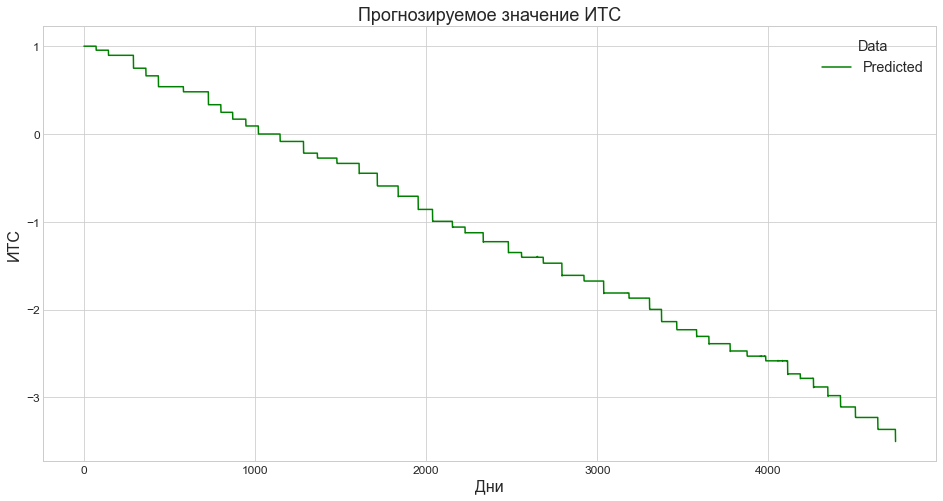

In [20]:
fig1, ax1 = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k')
ax1.set_title('Прогнозируемое значение ИТС', fontsize=18)
ax1.plot(range(len(ITS_predicted)), ITS_predicted.reshape((len(ITS_predicted),)), 'g', label = 'Predicted')
ax1.set_xlabel('Дни', fontsize=16)
ax1.set_ylabel('ИТС', fontsize=16)
ax1.legend(loc='best', fontsize='x-large', title="Data", title_fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [21]:
ITS_predicted_real = scaler.inverse_transform(ITS_predicted)

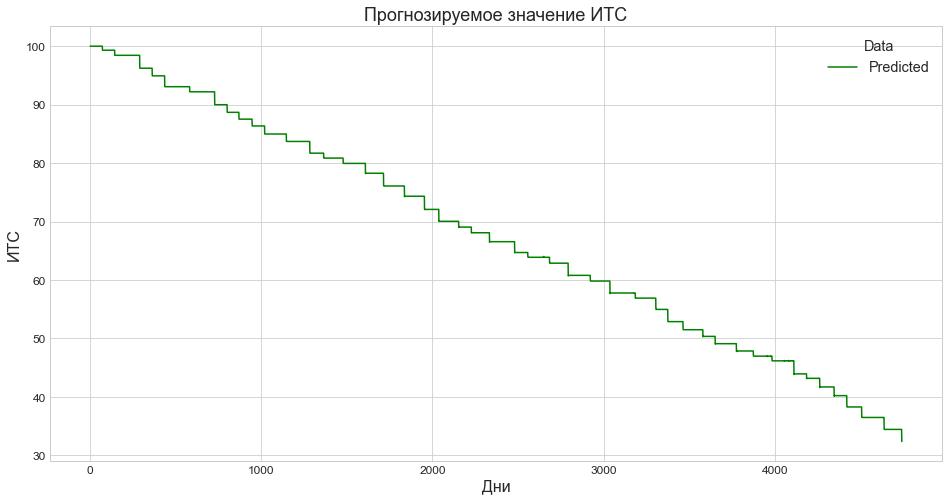

In [23]:
fig1, ax1 = plt.subplots(figsize=(16,8), facecolor='w', edgecolor='k')
ax1.set_title('Прогнозируемое значение ИТС', fontsize=18)
ax1.plot(range(len(ITS_predicted_real)), ITS_predicted_real.reshape((len(ITS_predicted_real),)), 'g', label = 'Predicted')
ax1.set_xlabel('Дни', fontsize=16)
ax1.set_ylabel('ИТС', fontsize=16)
ax1.legend(loc='best', fontsize='x-large', title="Data", title_fontsize='x-large')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()